In [0]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
transform = transforms.ToTensor()
batch_size = 20
num_workers = 0
valid_size = 0.2

train_data = datasets.MNIST(root='data', train=True, 
                            download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False, 
                            download=True, transform=transform)

In [0]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split] 

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

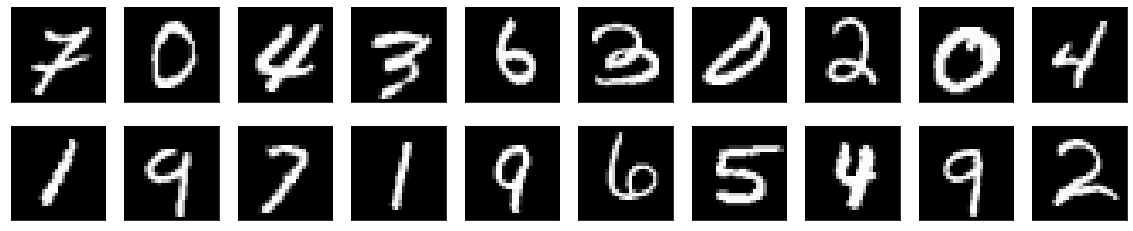

In [0]:
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(20, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hl1 = nn.Linear(784, 512)
        self.hl2 = nn.Linear(512, 256)
        self.hl3 = nn.Linear(256, 10)

        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        #flatten the array
        x = x.view(-1, 784)
        x = self.drop(F.relu(self.hl1(x)))
        x = self.drop(F.relu(self.hl2(x)))
        x = F.log_softmax(self.hl3(x), dim=1)

        return x

In [0]:
#define model, loss function and optimizer
from torch import optim

model = NeuralNet()

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr=0.003)

In [0]:
#train model
epochs = 20

valid_loss_min = np.Inf

for e in range(epochs):
    training_loss = 0
    valid_loss = 0
    for images, labels in train_loader:

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    for images, labels in valid_loader:
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
    print(f"\n----------------Epoch: {e+1} -----------------\n",
          "Training Loss: {:.3f}.. ".format(training_loss/len(train_loader)),
          "Validation Loss: {:.3f}.. ".format(valid_loss/len(valid_loader)))
    
    if valid_loss <= valid_loss_min:
        print(f'Validation decreased: {valid_loss_min} ----> {valid_loss}')
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


----------------Epoch: 1 -----------------
 Training Loss: 0.101..  Validation Loss: 0.366.. 
Validation decreased: inf ----> 219.5523676937599

----------------Epoch: 2 -----------------
 Training Loss: 0.100..  Validation Loss: 0.417.. 

----------------Epoch: 3 -----------------
 Training Loss: 0.092..  Validation Loss: 0.462.. 

----------------Epoch: 4 -----------------
 Training Loss: 0.111..  Validation Loss: 0.401.. 

----------------Epoch: 5 -----------------
 Training Loss: 0.094..  Validation Loss: 0.493.. 

----------------Epoch: 6 -----------------
 Training Loss: 0.087..  Validation Loss: 0.301.. 
Validation decreased: 219.5523676937599 ----> 180.4969422977807

----------------Epoch: 7 -----------------
 Training Loss: 0.095..  Validation Loss: 0.450.. 

----------------Epoch: 8 -----------------
 Training Loss: 0.100..  Validation Loss: 0.516.. 

----------------Epoch: 9 -----------------
 Training Loss: 0.085..  Validation Loss: 0.393.. 

----------------Epoch: 10 ----

In [35]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [36]:
with torch.no_grad():
            test_loss = 0
            accuracy = 0
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_value, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            print("Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Test Loss: 0.437..  Test Accuracy: 0.966


In [0]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

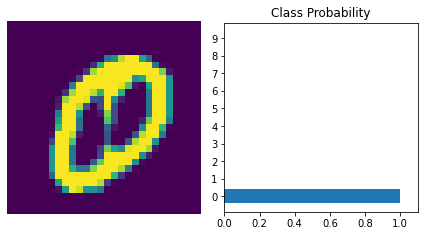

In [38]:
images, labels = next(iter(train_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)